# Pre-processing Notebook

*Author*: Michael Haines | mhaines2@illinois.edu

Use this notebook to extract and pre-process the data. This is the code that was used to produe the artifacts that already exist in the repo. It will some time to run to completion and isn't strictly required, since the output artifacts have already been pushed to the repo. 

## Pre-requisites

Assuming that you have already cloned the repo, follow the instructions in the `README.md` to add the MIMIC-IV dataset to the correct folder. This code pre-processes the raw data into something that can be used to train the BERT-based models.

## Install & Import Runtime Dependencies

In [ ]:
!pip install -r requirements.txt

In [29]:
import sys
import importlib
import os
import pandas as pd
import pickle
import torch
importlib.reload(torch)
import torch
from torch import *
import warnings

# Adding module
warnings.filterwarnings('ignore')
module_path='./tokenization'
if module_path not in sys.path:
    sys.path.append(module_path)
module_path='./tokenization/preprocessing'
if module_path not in sys.path:
    sys.path.append(module_path)
module_path='./tokenization/preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
module_path='./tokenization/preprocessing/hosp_module_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
module_path='./tokenization/utils'
if module_path not in sys.path:
    sys.path.append(module_path)

# Pre-processing
import day_intervals_cohort_v2
importlib.reload(day_intervals_cohort_v2)
import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *
import feature_selection_icu
importlib.reload(feature_selection_icu)
import feature_selection_icu
from feature_selection_icu import *
import data_generation_icu
importlib.reload(data_generation_icu)
import data_generation_icu
import tokenization
importlib.reload(tokenization)
import tokenization
from tokenization import *


## Dataset Pre-processing

**NOTE**: The pre-processing steps are not required, as the output of the pre-processing is already included in the repo. The code is included here for reference. If you are only interested in reproducing the experiments, please skip this section.

### Building Features Using Sample ICU Dataset

The following code extracts a sample cohort from the ICU dataset, limited to 10,000 admissions.

In [23]:
path = "sample"
cohort_output_icu = day_intervals_cohort_v2.extract_data("ICU",
                                                         "Mortality",
                                                         0,
                                                         "No Disease Filter",
                                                         "data",
                                                         "",
                                                         limit=10000,
                                                         path=path)

===========MIMIC-IV v2.0============
EXTRACTING FOR: | ICU | MORTALITY | 0 |
[ MORTALITY LABELS FINISHED ]
[ COHORT SUCCESSFULLY SAVED ]
[ SUMMARY SUCCESSFULLY SAVED ]
Mortality FOR ICU DATA
# Admission Records: 10000
# Patients: 9222
# Positive cases: 661
# Negative cases: 9339


Next, we create the features from the cohort data:

In [13]:
feature_icu(cohort_output_icu, "data/mimiciv/2.0", True, False, False, True, True, path=path)

[EXTRACTING DIAGNOSIS DATA]
# unique ICD-9 codes 3999
# unique ICD-10 codes 5000
# unique ICD-10 codes (After converting ICD-9 to ICD-10) 5359
# unique ICD-10 codes (After clinical gruping ICD-10 codes) 1196
# Admissions:   9994
Total rows 178152
[SUCCESSFULLY SAVED DIAGNOSIS DATA]
[EXTRACTING PROCEDURES DATA]
# Unique Events:   156
# Admissions:   9944
Total rows 94138
[SUCCESSFULLY SAVED PROCEDURES DATA]
[EXTRACTING MEDICATIONS DATA]
# of unique type of drug:  164
# Admissions:   9455
# Total rows 672477
[SUCCESSFULLY SAVED MEDICATIONS DATA]


Next, we pre-process the features:

In [14]:
preprocess_features_icu(cohort_output_icu, True, "Convert ICD-9 to ICD-10 and group ICD-10 codes", False, False, False, 0, 0, path=path)

[PROCESSING DIAGNOSIS DATA]
Total number of rows 168751
[SUCCESSFULLY SAVED DIAGNOSIS DATA]


Next, we generate the feature summary statistics:

In [16]:
generate_summary_icu(True, True, True, False, False, path=path)

[GENERATING FEATURE SUMMARY]
[SUCCESSFULLY SAVED FEATURE SUMMARY]


Next, we process the time series features to 1-hour buckets. We are defining the anchor event to be admission to the ICU, the observation window to be 72 hours, and for the prediction window for mortality to be 6 hours. 

In [27]:
!rm -rf ./data/sample/csv
!mkdir ./data/sample/csv
data_generation_icu.Generator(cohort_output_icu, True, False, False, True, True, False, False, True, False, 72, 1, 8, path=path)

[ READ COHORT ]
[ ======READING DIAGNOSIS ]
[ ======READING PROCEDURES ]
[ ======READING MEDICATIONS ]
[ READ ALL FEATURES ]
include_time 72
[ PROCESSED TIME SERIES TO EQUAL LENGTH  ]


100%|██████████| 72/72 [00:01<00:00, 57.20it/s]


bucket 1
[ PROCESSED TIME SERIES TO EQUAL TIME INTERVAL ]
72


100%|██████████| 2833/2833 [10:48<00:00,  4.37it/s]


[ SUCCESSFULLY SAVED DATA DICTIONARIES ]


Finally, we are tokenizing the data set into something that can be used as inputs to the BERT-based models.

In [30]:
tokens=tokenization.BEHRT_models(True,True,True,False,False,True,False,path=path).tokens

if not os.path.exists(f"./data/{path}/tokens"):
    os.makedirs(f"./data/{path}/tokens")
tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels = tokens
tokenized_src.to_csv(f'./data/{path}/tokens/tokenized_src.csv', header=None)
tokenized_age.to_csv(f'./data/{path}/tokens/tokenized_age.csv', header=None)
tokenized_gender.to_csv(f'./data/{path}/tokens/tokenized_gender.csv', header=None)
tokenized_ethni.to_csv(f'./data/{path}/tokens/tokenized_ethni.csv', header=None)
tokenized_ins.to_csv(f'./data/{path}/tokens/tokenized_ins.csv', header=None)
tokenized_labels.to_csv(f'./data/{path}/tokens/tokenized_labels.csv', header=None)

STARTING READING FILES.


 74%|███████▍  | 2107/2833 [04:54<02:03,  5.88it/s]

### Building Features Using Complete ICU Dataset

The following code extracts the full cohort from the ICU dataset and performs all of the same steps that were performed on the previous dataset.

In [ ]:
path = "full"
cohort_output_icu = day_intervals_cohort_v2.extract_data("ICU",
                                                         "Mortality",
                                                         0,
                                                         "No Disease Filter",
                                                         "data",
                                                         "",
                                                         path=path)
feature_icu(cohort_output_icu, "data/mimiciv/2.0", True, False, False, True, True, path=path)
preprocess_features_icu(cohort_output_icu, True, "Convert ICD-9 to ICD-10 and group ICD-10 codes", False, False, False, 0, 0, path=path)
generate_summary_icu(True, True, True, False, False, path=path)
!rm -rf ./data/sample/csv
!mkdir ./data/sample/csv
data_generation_icu.Generator(cohort_output_icu, True, False, False, True, True, False, False, True, False, 72, 1, 8, path=path)
tokens=tokenization.BEHRT_models(True,True,True,False,False,True,False,path=path).tokens
if not os.path.exists(f"./data/{path}/tokens"):
    os.makedirs(f"./data/{path}/tokens")
tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels = tokens
tokenized_src.to_csv(f'./data/{path}/tokens/tokenized_src.csv', header=None)
tokenized_age.to_csv(f'./data/{path}/tokens/tokenized_age.csv', header=None)
tokenized_gender.to_csv(f'./data/{path}/tokens/tokenized_gender.csv', header=None)
tokenized_ethni.to_csv(f'./data/{path}/tokens/tokenized_ethni.csv', header=None)
tokenized_ins.to_csv(f'./data/{path}/tokens/tokenized_ins.csv', header=None)
tokenized_labels.to_csv(f'./data/{path}/tokens/tokenized_labels.csv', header=None)

Let's plot the distributions of the features and save the outputs to the `/images` path:

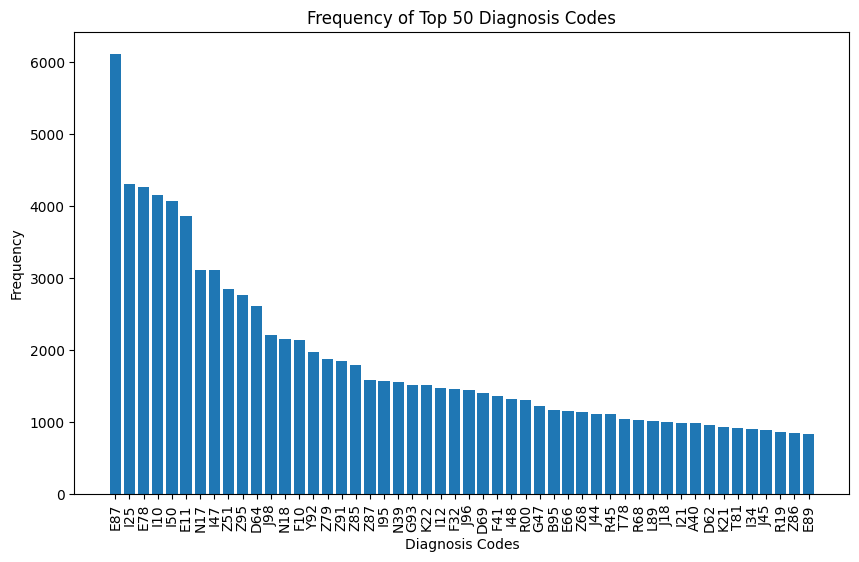

In [ ]:

import matplotlib.pyplot as plt

if not os.path.exists(f"./images/{path}"):
    os.makedirs(f"./images/{path}")

df = pd.read_csv(f'./data/{path}/summary/diag_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Diagnosis Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['new_icd_code'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Diagnosis Codes')
plt.savefig(f'images/{path}/diag_freq.png')
plt.show()

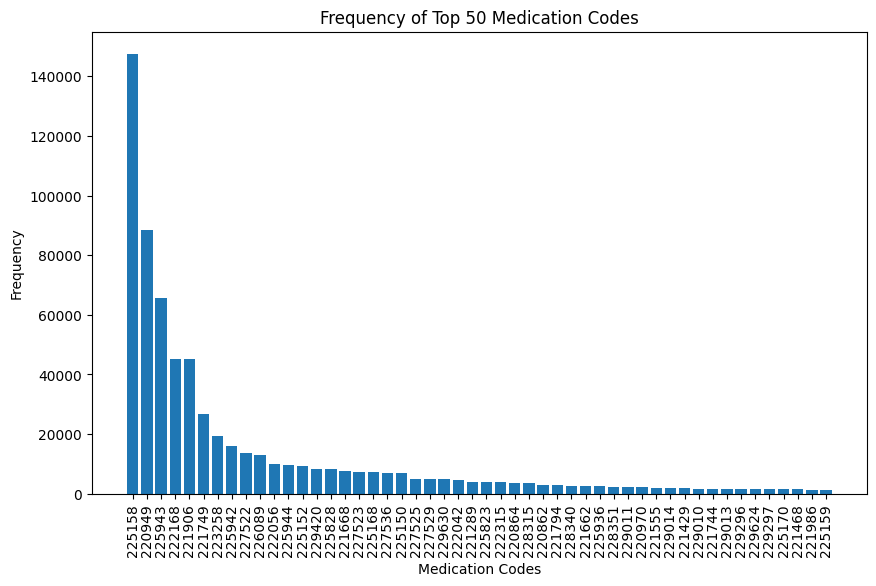

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv(f'./data/{path}/summary/med_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Medication Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['itemid'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Medication Codes')
plt.savefig(f'images/{path}/med_freq.png')
plt.show()

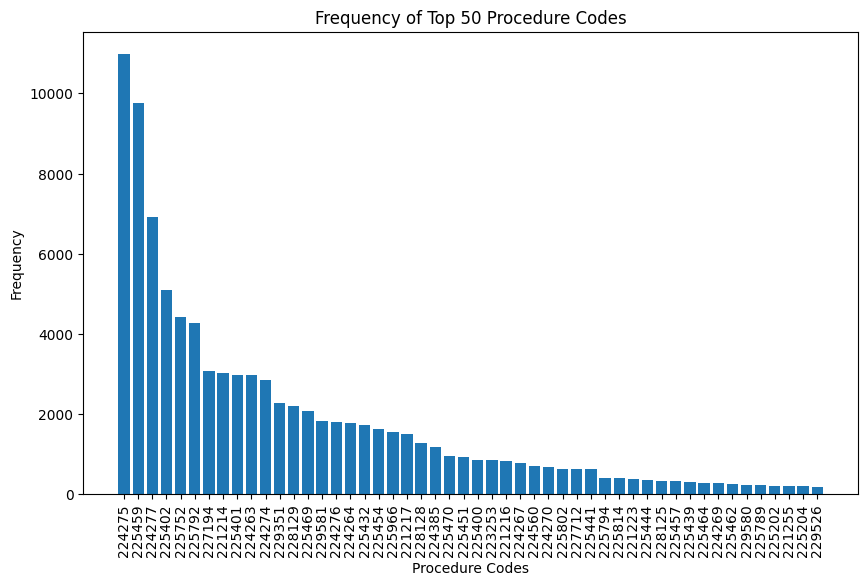

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv(f'./data/{path}/summary/proc_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Procedure Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['itemid'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Procedure Codes')
plt.savefig(f'images/{path}/proc_freq.png')
plt.show()